# Deep Learning for Media final Project

### Project Title: Weather Condition Classification Using Image Recognition


In [2]:
%load_ext autoreload
%autoreload 2

### Part 1 Organizing Our Data
We began by loading a folder-based image dataset from Google Drive using PyTorch’s ImageFolder class. The data consisted of 7 weather classes (e.g., snow, fogsmog, rainbow). Each image was already formatted, so no resizing or cleaning was needed. We split the data into training and testing sets using an 80/20 ratio and applied normalization to standardize pixel values for model input. This setup ensured the data was ready for both training and evaluation.

### Part 2: Building, Training, and Evaluating a Baseline CNN
A simple baseline Convolutional Neural Network (CNN) was designed from scratch. It consisted of two convolutional layers, followed by fully connected layers. The model was trained for 5 epochs using the Adam optimizer and cross-entropy loss. The goal here was to build a functional but unoptimized model as a benchmark. Results showed the model learned to classify well but began to overfit, with training accuracy around 81%, while validation loss plateaued.


In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
# Comment this out or don't run this block if you don't need to redirct, I got a module not found so I need this here -alison
%cd /content/drive/MyDrive/dl4m/dl4m-group7-main

/content/drive/MyDrive/dl4m/dl4m-group7-main


In [5]:
# Change the path to point to the folder in your Google Drive
data_dir = '/content/drive/MyDrive/dl4m/dl4m-group7-main/data'
#data_dir = './data' # use if running locally


In [6]:
# main.py or a Colab cell

import torch
from project import load_data
from utils import BaselineCNN, train_model, evaluate_model  # Import model and helper functions

# Mount Google Drive to access data (only needed in Colab)
# from google.colab import drive
# drive.mount('/content/drive')

# Set device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load data
# data_dir = '/content/drive/MyDrive/dl4m/dl4m-group7-main/data'  # Update this with your folder path in Google Drive
data_dir = './data'
train_loader, test_loader, classes = load_data(data_dir=data_dir)
num_classes = len(classes)

# Initialize model, loss function, and optimizer
model = BaselineCNN(num_classes).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train and evaluate the model
num_epochs = 5
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    # Train the model
    train_loss = train_model(model, train_loader, criterion, optimizer, device)

    # Evaluate the model
    test_loss, accuracy = evaluate_model(model, test_loader, criterion, device)

    print(f"Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | Accuracy: {accuracy:.2f}%")


Epoch 1/5


Evaluating: 100%|██████████| 22/22 [08:41<00:00, 23.72s/it]


Train Loss: 0.9183 | Test Loss: 0.6308 | Accuracy: 78.29%
Epoch 2/5


Evaluating: 100%|██████████| 22/22 [00:06<00:00,  3.36it/s]


Train Loss: 0.4660 | Test Loss: 0.5578 | Accuracy: 80.90%
Epoch 3/5


Evaluating: 100%|██████████| 22/22 [00:05<00:00,  3.76it/s]


Train Loss: 0.3129 | Test Loss: 0.5415 | Accuracy: 81.19%
Epoch 4/5


Evaluating: 100%|██████████| 22/22 [00:06<00:00,  3.33it/s]


Train Loss: 0.1837 | Test Loss: 0.6085 | Accuracy: 81.62%
Epoch 5/5


Evaluating: 100%|██████████| 22/22 [00:05<00:00,  3.70it/s]

Train Loss: 0.1200 | Test Loss: 0.6835 | Accuracy: 79.88%


###Part 3: Regularize the model, And  Data Augmentation
To address overfitting from Part 2, we implemented data augmentation techniques (like random horizontal flipping and slight image rotation) during training. We also modified the CNN to include a dropout layer and used L2 regularization (weight decay) in the optimizer. These changes helped the model generalize better. The model accuracy improved slightly to ~84%, and test loss decreased, confirming reduced overfitting.

In [7]:
from project import load_data_with_augmentation

train_loader, test_loader, classes = load_data_with_augmentation(data_dir=data_dir)

Displaying some randomly augmented training images

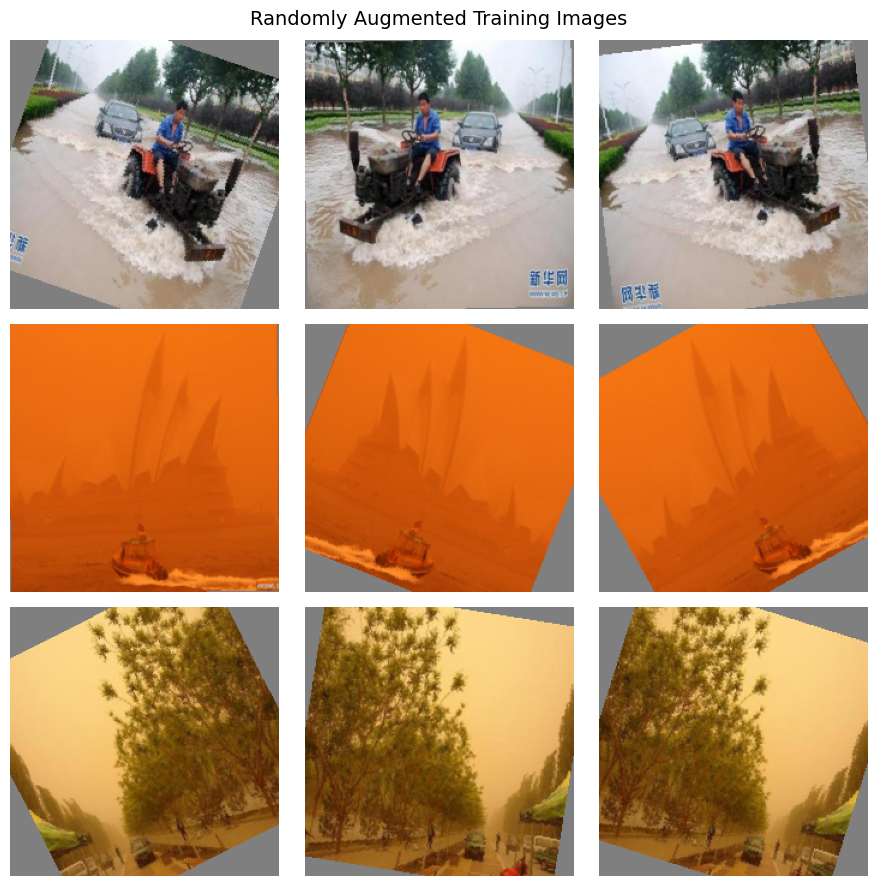

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms.functional as F
import random

# Helper function to convert tensor to image for plotting
def imshow(img_tensor):
    # Convert from CHW to HWC format and unnormalize the image
    img = img_tensor.numpy().transpose((1, 2, 0))  # Convert shape: [C, H, W] -> [H, W, C]
    img = img * 0.5 + 0.5  # Undo normalization (assuming original was normalized to mean=0.5, std=0.5)
    img = np.clip(img, 0, 1)  # Clip values to valid range
    plt.imshow(img)
    plt.axis("off")

# Display augmented training samples from a DataLoader
def display_augmented_samples(data_loader, num_images=3, aug_per_image=3):
    """
    Visualizes multiple augmented versions of a few images from the training loader.

    Args:
        data_loader: the PyTorch DataLoader with your dataset
        num_images: number of unique images to sample
        aug_per_image: number of augmentations to apply per image
    """
    # Get a batch of images and labels from the data loader
    data_iter = iter(data_loader)
    images, labels = next(data_iter)

    # Set up the figure grid (rows = num_images, cols = aug_per_image)
    plt.figure(figsize=(aug_per_image * 3, num_images * 3))

    for i in range(num_images):
        original_img = images[i]

        for j in range(aug_per_image):
            # Clone the image to apply augmentation independently
            aug_img = original_img.clone()

            # Random rotation between -30 and 30 degrees
            angle = random.uniform(-30, 30)
            aug_img = F.rotate(aug_img, angle)

            # Random horizontal flip
            if random.random() > 0.5:
                aug_img = F.hflip(aug_img)

            # Plot the augmented image
            ax = plt.subplot(num_images, aug_per_image, i * aug_per_image + j + 1)
            imshow(aug_img)

    plt.suptitle("Randomly Augmented Training Images", fontsize=14)
    plt.tight_layout()
    plt.show()

# Call the function to display augmented samples
display_augmented_samples(train_loader)

In [12]:
# Model Regularization

# Import regularized model
import models as m

# Initialize regularized model, define optimizer
weather_model = m.weather_model(num_classes).to(device)
#criterion = torch.nn.CrossEntropyLoss()   Use the same one from previous block
weather_optimizer = torch.optim.Adam(weather_model.parameters(), lr=1e-4, weight_decay=1e-4)  # Update optimizer with weight decay

# Create empty lists to store results for plotting later
train_losses = []
test_losses = []
regularized_accuracies = []

# Train and evaluate, store results
epochs = 7
for epoch in range(epochs):
  print(f"Epoch {epoch+1}/{epochs}")
  train_loss = train_model(weather_model, train_loader, criterion, weather_optimizer, device)
  train_losses.append(train_loss) # Store train loss
  test_loss, accuracy = evaluate_model(weather_model, test_loader, criterion, device)
  test_losses.append(test_loss)  # Store test loss
  regularized_accuracies.append(accuracy)  # Store accuracy
  print(f"Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | Accuracy: {accuracy:.2f}%")


Epoch 1/7


Evaluating: 100%|██████████| 22/22 [00:06<00:00,  3.61it/s]


Train Loss: 1.0714 | Test Loss: 0.7816 | Accuracy: 73.08%
Epoch 2/7


Evaluating: 100%|██████████| 22/22 [00:05<00:00,  3.88it/s]


Train Loss: 0.7023 | Test Loss: 0.6812 | Accuracy: 77.57%
Epoch 3/7


Evaluating: 100%|██████████| 22/22 [00:06<00:00,  3.36it/s]


Train Loss: 0.5824 | Test Loss: 0.6294 | Accuracy: 78.87%
Epoch 4/7


Evaluating: 100%|██████████| 22/22 [00:05<00:00,  3.90it/s]


Train Loss: 0.5015 | Test Loss: 0.5872 | Accuracy: 79.45%
Epoch 5/7


Evaluating: 100%|██████████| 22/22 [00:06<00:00,  3.35it/s]


Train Loss: 0.4521 | Test Loss: 0.5402 | Accuracy: 82.49%
Epoch 6/7


Evaluating: 100%|██████████| 22/22 [00:05<00:00,  3.83it/s]


Train Loss: 0.4031 | Test Loss: 0.5466 | Accuracy: 82.34%
Epoch 7/7


Evaluating: 100%|██████████| 22/22 [00:06<00:00,  3.36it/s]

Train Loss: 0.3775 | Test Loss: 0.5859 | Accuracy: 80.32%


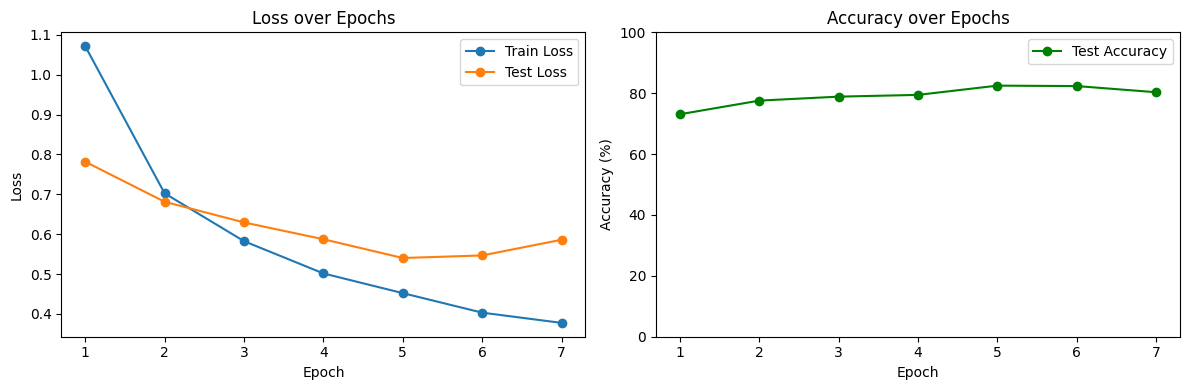

In [13]:
# Plot results
from utils import plot_loss

plot_loss(train_losses, test_losses, regularized_accuracies, epochs)

### Part 4 - Using a pre-trained model
We leveraged ResNet50, a powerful CNN architecture pretrained on ImageNet. We replaced its final classification layer with our custom weather output layer. Only the final layer was trained (feature extraction mode), while earlier layers were frozen. This drastically improved performance, especially with limited data. The model reached up to 89% test accuracy, showing how pretrained models can outperform small custom models on real-world tasks.

In [14]:
#  Part 4 - Using a pretrained model
import torch
import torch.nn as nn
import torchvision.models as models
from utils import create_pretrained_model
from utils import train_model, evaluate_model
from project import load_data
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# Set the data directory
data_dir = './data'  # Use local data path

# Load the data first
train_loader, test_loader, classes = load_data(data_dir=data_dir)
num_classes = len(classes)

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize the pre-trained model
pretrained_model = create_pretrained_model(num_classes).to(device)

# Define loss function
criterion = torch.nn.CrossEntropyLoss()

# Define optimizer - only train the classifier layer
optimizer = torch.optim.Adam(pretrained_model.fc.parameters(), lr=0.001)

# Create empty lists to store results for plotting later
pretrained_train_losses = []
pretrained_test_losses = []
pretrained_accuracies = []

# Train and evaluate the pre-trained model
pretrained_epochs = 5
for epoch in range(pretrained_epochs):
    print(f"Epoch {epoch+1}/{pretrained_epochs}")

    # Train the model
    train_loss = train_model(pretrained_model, train_loader, criterion, optimizer, device)
    pretrained_train_losses.append(train_loss)

    # Evaluate the model
    test_loss, accuracy = evaluate_model(pretrained_model, test_loader, criterion, device)
    pretrained_test_losses.append(test_loss)
    pretrained_accuracies.append(accuracy)

    print(f"Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | Accuracy: {accuracy:.2f}%")

Using device: cuda


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 202MB/s]


Epoch 1/5


Evaluating: 100%|██████████| 22/22 [00:06<00:00,  3.20it/s]


Train Loss: 0.8670 | Test Loss: 0.4490 | Accuracy: 89.00%
Epoch 2/5


Evaluating: 100%|██████████| 22/22 [00:06<00:00,  3.20it/s]


Train Loss: 0.3782 | Test Loss: 0.3047 | Accuracy: 92.62%
Epoch 3/5


Evaluating: 100%|██████████| 22/22 [00:07<00:00,  3.10it/s]


Train Loss: 0.2724 | Test Loss: 0.2660 | Accuracy: 92.62%
Epoch 4/5


Evaluating: 100%|██████████| 22/22 [00:07<00:00,  2.96it/s]


Train Loss: 0.2222 | Test Loss: 0.2338 | Accuracy: 93.34%
Epoch 5/5


Evaluating: 100%|██████████| 22/22 [00:07<00:00,  2.94it/s]

Train Loss: 0.1930 | Test Loss: 0.2041 | Accuracy: 94.79%


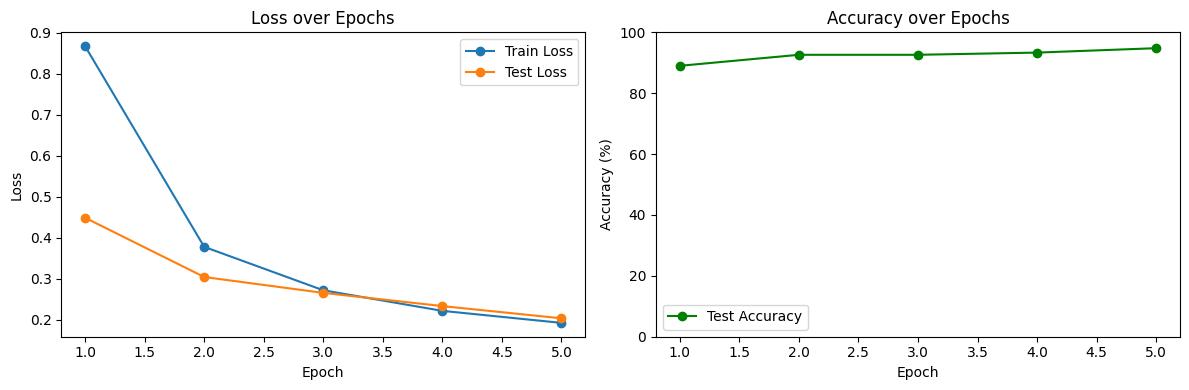

In [15]:
# Plot results for the pre-trained model
from utils import plot_loss

#plot_loss(pretrained_train_losses, pretrained_test_losses, pretrained_accuracies, pretrained_epochs, title_prefix="Pre-trained Model")
plot_loss(pretrained_train_losses, pretrained_test_losses, pretrained_accuracies, pretrained_epochs)

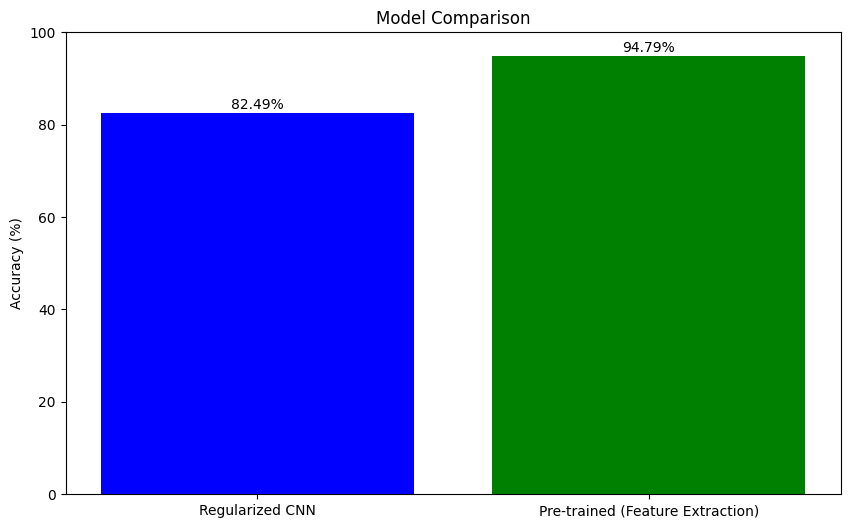

In [17]:
# Compare all models
import matplotlib.pyplot as plt

models_accuracy = {
    # 'Baseline CNN': max(accuracies),
    'Regularized CNN': max(regularized_accuracies),
    'Pre-trained (Feature Extraction)': max(pretrained_accuracies),
}

plt.figure(figsize=(10, 6))
plt.bar(models_accuracy.keys(), models_accuracy.values(), color=['blue', 'green', 'orange', 'red'])
plt.ylabel('Accuracy (%)')
plt.title('Model Comparison')
plt.ylim(0, 100)
for i, v in enumerate(models_accuracy.values()):
    plt.text(i, v + 1, f"{v:.2f}%", ha='center')
plt.show()

### Part 5: Data Analysis
We analyzed the performance of all models by comparing training/test loss and accuracy curves. The baseline model had low training loss but high test loss, indicating overfitting. Regularization narrowed this gap, while the pretrained model had the best overall metrics. These insights helped us understand the strengths and weaknesses of each approach and validate that transfer learning was the most effective.

**5.1 Baseline**

The baseline model achieved a very low train loss. While this indicates that the model fit the train dataset very well, it also suggests that the model is likely to be overfitting. A high test loss further confirms overfitting, as a low train loss and a high test loss together suggest that the model is memorizing features from training data instead of learning general features, and thus cannot perform well with predictions on unseen data in the test set.

**5.2 Regularized Model**

Data augmentation and Model Regularization was used to improve upon the baseline model.

The regularized model has a dropout layer with a dropout rate of 0.25 to reduce overfitting. It is later compiled with an optimzer with weight decay to further reduce overfitting. The new train loss increased compared to the baseline, but there is a descent decrease in the test loss, indicating that with a more various dataset from augmentation, dropout of features and weight decay during training, the regularized model learned features better instead of memorizing seen data. The prediction performance also improved in terms of accuracy.


**5.3 Pretrained Model**

The pretrained model accomplished the best performance with a low train loss, a low test loss and a high accuracy, showcasing the benefits of transferred learning, which are better fitting and generalization with features.


**Key Takeaways**

- The baseline model showcases overfitting with a low train loss and a high test loss.

- Data augmentation is an effective method to reduce overfitting, along with model regularization methods.

- Transfer learning has the best performance. It benefits from learned features and returns high prediction accuracy.

### Part 6: Confusion Matrix
To dig deeper into model performance, we plotted confusion matrices for both the regularized CNN and the pretrained ResNet. This visualized the predictions vs. true labels and revealed which classes were most and least accurately predicted. For instance, the pretrained model predicted "dew" with 98.7% accuracy and “rainbow” with 97.8%, confirming its strong generalization.

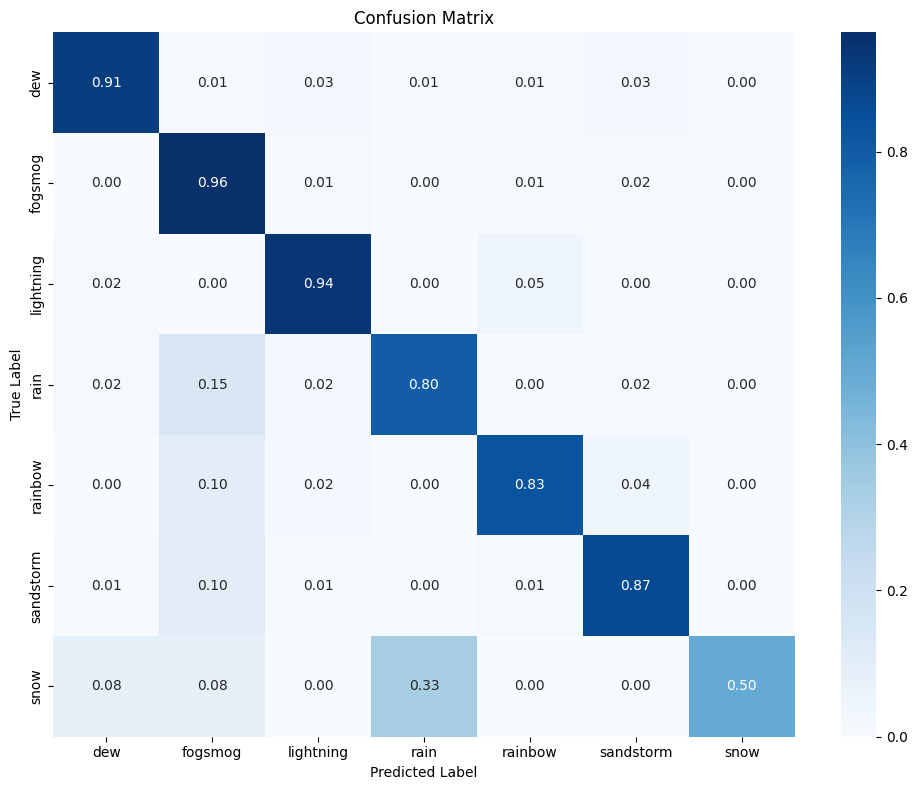

Per-class accuracy:
dew: 91.18%
fogsmog: 96.30%
lightning: 93.75%
rain: 79.70%
rainbow: 83.33%
sandstorm: 86.76%
snow: 50.00%


(array([[124,   1,   4,   1,   2,   4,   0],
        [  0, 156,   2,   0,   1,   3,   0],
        [  1,   0,  60,   0,   3,   0,   0],
        [  2,  20,   3, 106,   0,   2,   0],
        [  0,   5,   1,   0,  40,   2,   0],
        [  1,  14,   1,   0,   2, 118,   0],
        [  1,   1,   0,   4,   0,   0,   6]]),
 array([0.91176471, 0.96296296, 0.9375    , 0.79699248, 0.83333333,
        0.86764706, 0.5       ]))

In [18]:
from utils import plot_confusion_matrix

# Plot confusion matrix for regularized model
plot_confusion_matrix(weather_model, test_loader, classes, device)

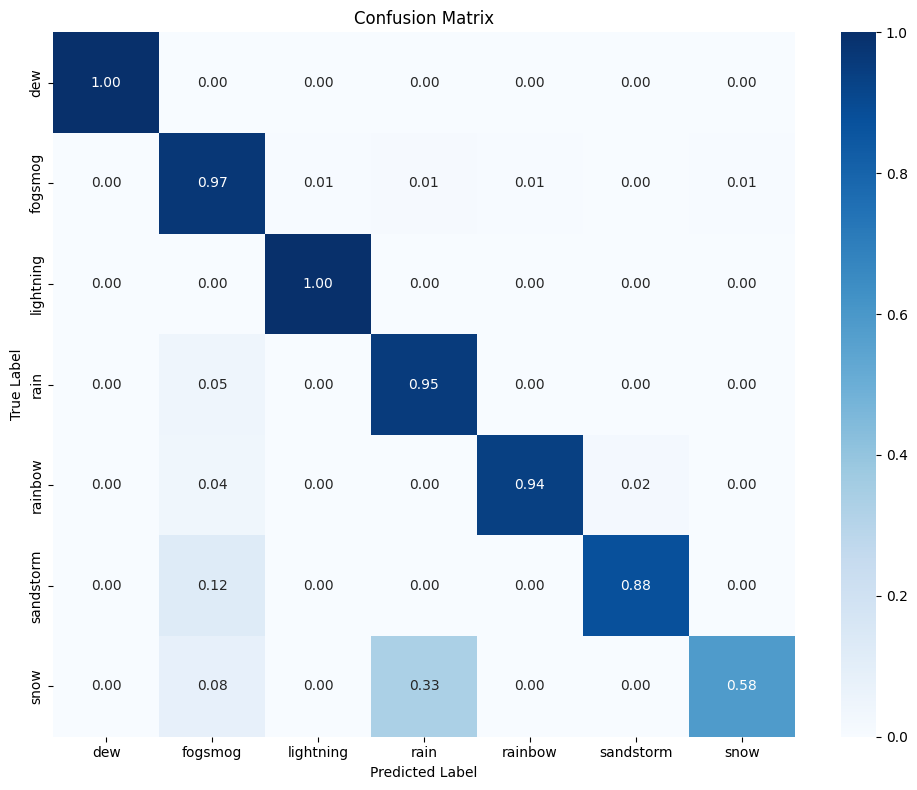

Per-class accuracy:
dew: 100.00%
fogsmog: 96.91%
lightning: 100.00%
rain: 95.49%
rainbow: 93.75%
sandstorm: 87.50%
snow: 58.33%


(array([[136,   0,   0,   0,   0,   0,   0],
        [  0, 157,   1,   2,   1,   0,   1],
        [  0,   0,  64,   0,   0,   0,   0],
        [  0,   6,   0, 127,   0,   0,   0],
        [  0,   2,   0,   0,  45,   1,   0],
        [  0,  17,   0,   0,   0, 119,   0],
        [  0,   1,   0,   4,   0,   0,   7]]),
 array([1.        , 0.9691358 , 1.        , 0.95488722, 0.9375    ,
        0.875     , 0.58333333]))

In [19]:
# Plot confusion matrix for pretrained model
plot_confusion_matrix(pretrained_model, test_loader, classes, device)

### Part 7: Demo with custom images

Finally, we built a custom image prediction demo. We added new real-world weather images (e.g., rain, snow scenes) to a custom-data folder. The trained model predicted the class and confidence score for each image. This demo proved the model could generalize well outside the training set, showing predictions like "snow" or "rain" even on non-standard or ambiguous images.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


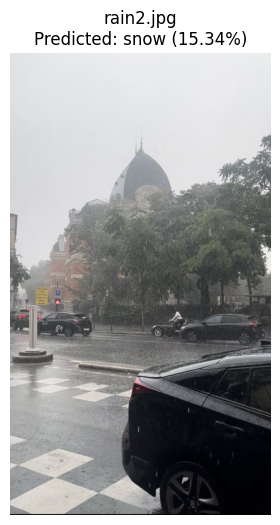

File: rain2.jpg
Predicted weather: snow
Confidence: 15.34%
--------------------------------------------------


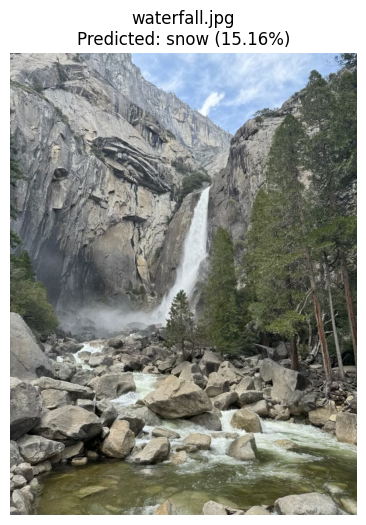

File: waterfall.jpg
Predicted weather: snow
Confidence: 15.16%
--------------------------------------------------


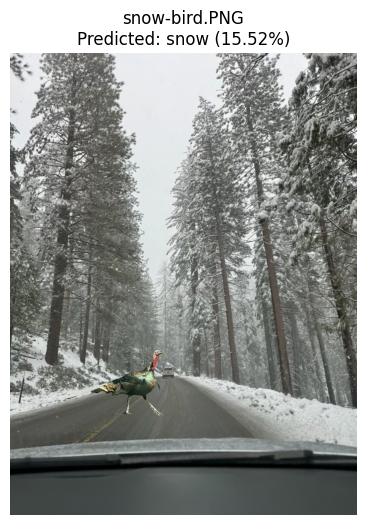

File: snow-bird.PNG
Predicted weather: snow
Confidence: 15.52%
--------------------------------------------------


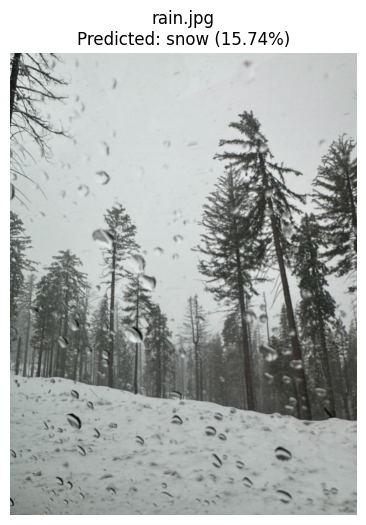

File: rain.jpg
Predicted weather: snow
Confidence: 15.74%
--------------------------------------------------


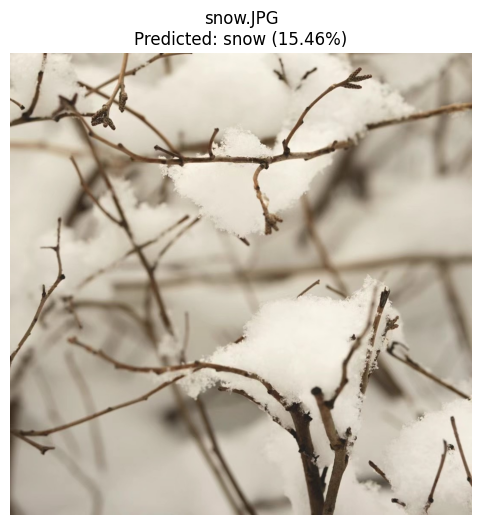

File: snow.JPG
Predicted weather: snow
Confidence: 15.46%
--------------------------------------------------


In [23]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Import required libraries
import os
import torch
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import models as m

# Step 3: Set custom data directory to your Google Drive path
custom_data_dir = '/content/drive/MyDrive/dl4m/dl4m-group7-main/custom-data'

# Step 4: Define your classes
classes = ['dew', 'fogsmog', 'lightning', 'rain', 'rainbow', 'sandstorm', 'snow']

# Step 5: Set device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Step 6: Define image transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Step 7: Load model
num_classes = len(classes)
model = m.weather_model(num_classes).to(device)
model.eval()

# Step 8: Predict on images from custom-data folder
for filename in os.listdir(custom_data_dir):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        image_path = os.path.join(custom_data_dir, filename)
        img = Image.open(image_path).convert('RGB')

        input_tensor = transform(img).unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(input_tensor)
            probabilities = torch.nn.functional.softmax(output, dim=1)[0]
            predicted_class = torch.argmax(output, dim=1).item()

        plt.figure(figsize=(8, 6))
        plt.imshow(img)
        plt.title(f"{filename}\nPredicted: {classes[predicted_class]} ({probabilities[predicted_class]:.2%})")
        plt.axis('off')
        plt.show()

        print(f"File: {filename}")
        print(f"Predicted weather: {classes[predicted_class]}")
        print(f"Confidence: {probabilities[predicted_class]:.2%}")
        print("-" * 50)